In [1]:
import sys
sys.path.append('../../neurodynlib/')
import neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np

## Create the network neurons

In [2]:
x = nd.LifNeuron()

In [3]:
# Parameters from Song&Abbott 2001
x.set_neuron_parameters(C=50*pF, gL=2.5*nS, EL=-74*mV, VT=-54*mV, V_res=-60*mV)  
x.set_excitatory_receptors('SIMPLE_E')
x.set_inhibitory_receptors('SIMPLE_I')
x.set_neuron_parameters(tau_e=5*ms, tau_i=5*ms)  # Not sure what tau_i should be

In [4]:
x.get_neuron_parameters()

{'EL': -74. * mvolt,
 'V_res': -60. * mvolt,
 'VT': -54. * mvolt,
 'gL': 2.5 * nsiemens,
 'C': 50. * pfarad,
 'refractory_period': 2. * msecond,
 'tau_e': 5. * msecond,
 'tau_i': 5. * msecond}

In [5]:
# Create a network of 200 LIF neurons
network_neurons = x.make_neuron_group(200)
network_neurons

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

In [6]:
# Add background input
# Poisson input at 500 Hz, weight 0.096; except Fig 5 higher weight
background_input = b2.PoissonInput(network_neurons, 'ge', 1, 500*Hz, weight=0.096*siemens)

## Create input neurons

In [7]:
# Stimulus space = scalars from 0 to 1000
N_inputs = 1000
a_inputs = np.arange(0, 1000, 1.0)

In [8]:
def inputneuron(a, s):
    R_0 = 10.0*Hz
    R_1 = 80.0*Hz
    sigma = 100.0
    
    rate = R_0 + R_1 * (np.exp(-(s-a)**2/(2*sigma**2)) + np.exp(-(s+1000-a)**2/(2*sigma**2)) + np.exp(-(s-1000-a)**2/(2*sigma**2)))
    
    return rate

WARNING    /home/henhok/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
 [py.warnings]


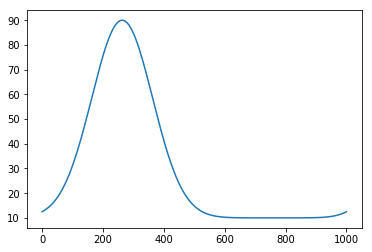

In [9]:
a = 263.23783273
s_values = np.linspace(0,1000.0,1e4)
r_values = [inputneuron(a, s) for s in s_values]
plt.plot(s_values, r_values)

Text(0.5, 0, 'Time [ms]')

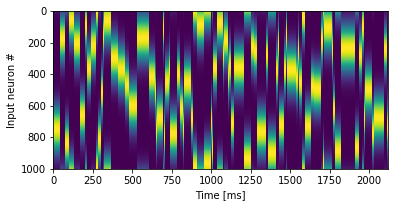

In [10]:
# Create brief presentations of stimulus at random locations
# Length of each presentation chosen from exponential distribution with mean of 20 ms
N_presentations = 100
presentation_mean_duration = 20  # in milliseconds

# Get random presentation lengths
presentation_durations = np.random.exponential(scale=presentation_mean_duration, size=N_presentations).astype(int)
total_presentation_duration = np.sum(presentation_durations)  # in milliseconds

# Create a matrix of size N_inputs x total_duration_dt_1ms
presentation_matrix = np.zeros((N_inputs, total_presentation_duration))
next_pres_start = 0

# Pick a random stimulus, then get rate of each of the 1000 input neurons
for i in range(N_presentations): 
    stimulus = np.random.uniform(0, 1000)
    stim_rates = np.array([[inputneuron(a, stimulus)] for a in a_inputs])
    # Add the rates to presentation duration-many columns
    dur = presentation_durations[i]
    presentation = np.tile(stim_rates, (1, dur))
    presentation_matrix[:, next_pres_start:next_pres_start+dur] = presentation
    next_pres_start = next_pres_start+dur
    
# Visualize the rate matrix
plt.imshow(presentation_matrix)
plt.ylabel('Input neuron #')
plt.xlabel('Time [ms]')

In [11]:
# Create PoissonGroup with the rates defined above 
# Brian2 TimedArray: time as the first and neuron index as the second dimension
presentations_array = b2.TimedArray(presentation_matrix.T, dt=1*ms)
input_group = b2.PoissonGroup(N_inputs, rates='presentations_array(t, i)')

## Connect everything

In [12]:
# Plasticity parameters
A_plus = 0.001
tau_plus = 20*ms
tau_minus = 20*ms  # Song&Abbott use alternatively 100*ms here (as long as tau_minus >= tau_plus)

# B = A_minus*tau_minus / (A_plus*tau_plus) aka the "STDP window function"
B_ff = 1.06
B_recur = 1.04

A_minus_ff = -B_ff * A_plus * tau_plus / tau_minus
A_minus_recur = -B_recur * A_plus * tau_plus / tau_minus

g_max = 0.02
g_inhib = 0.3 * g_max

dAplus = 1  # TODO!!
dAminus = 1  # TODO!!

In [13]:
# Input->network (20% probability; excitatory)

# Option 1: All-to-all excitatory connections in the network

# Option 2: Local excitatory connections and all-to-all uniform inhibitory connections